**1. Importing libraries and reading data**

In [1]:
#import all essential libraries
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.metrics import mean_squared_error,r2_score
## Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/DSProject/

Mounted at /content/drive/
/content/drive/My Drive/DSProject


In [3]:
data = pd.read_csv('b.csv', infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])
data.head(5)

,time,sensor_data
0,08-12-2018 9:30,29
1,08-12-2018 9:30,29
2,08-12-2018 9:29,41
3,08-12-2018 9:29,41
4,08-12-2018 9:29,31


In [4]:
data['time'] = pd.to_datetime(data['time'])
data.index = data['time']
data = data.drop(columns=["time"])
data

,sensor_data
time,
2018-08-12 09:30:00,29
2018-08-12 09:30:00,29
2018-08-12 09:29:00,41
2018-08-12 09:29:00,41
2018-08-12 09:29:00,31
...,...
2018-07-28 07:07:00,31
2018-07-28 07:07:00,31
2018-07-28 07:06:00,31


In [5]:
data.index.dtype

dtype('<M8[ns]')

In [6]:
data.describe

<bound method NDFrame.describe of                      sensor_data
time                            
2018-08-12 09:30:00           29
2018-08-12 09:30:00           29
2018-08-12 09:29:00           41
2018-08-12 09:29:00           41
2018-08-12 09:29:00           31
...                          ...
2018-07-28 07:07:00           31
2018-07-28 07:07:00           31
2018-07-28 07:06:00           31
2018-07-28 07:06:00           31
2018-07-28 07:06:00           31

[97606 rows x 1 columns]>

Read the txt file. Raw Data has the datetime field split into two different columns so we will merge it into single column  

In [7]:
data.head()

,sensor_data
time,
2018-08-12 09:30:00,29
2018-08-12 09:30:00,29
2018-08-12 09:29:00,41
2018-08-12 09:29:00,41
2018-08-12 09:29:00,31


In [8]:
data.describe()

,sensor_data
count,97606.000000
mean,35.053931
std,5.699825
min,21.000000
25%,30.000000
50%,35.000000
75%,40.000000
max,51.000000


**2. Data Preprocessing **

Do we have any missing values? Do we need all the columns?

In [9]:
## finding all columns that have nan:
data.columns[data.isnull().any()]

Index([], dtype='object')

Its important to clean the data and treat missing values. But filling in  with mean or zeros can skew the model a lot espeically for fields with high variance. 
So First step before filling in the missing values is to check linearity and variation in data. This problem is more tricky than it sounds as ideally for any time series, 
we would like to decompose it to see the trend and seasonality. But this tutorial is limited to providing a general workflow for LSTM based forecasting.

Below, we get a plot of how autocorelation of different signals change with lag to better model the imputation

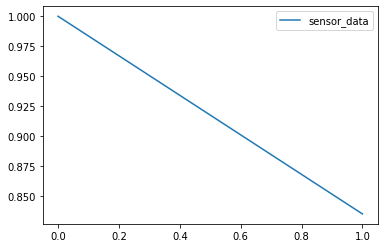

In [10]:
#To fill in missing values, first check for linearity in each column using autocorelation plots
def get_acf(data,lags): 
    frame = []
    for i in range(lags+1):
        frame.append(data.apply(lambda col: col.autocorr(i), axis=0))
    return pd.DataFrame(frame).plot.line()
get_acf(data,1)

Seems like acfs start dropping after 10 lags for majority of signals. So lets do linear interpolation but with a limit of 10 

In [11]:
#fill in missing values using linear interpolation with limit to 10 using autocorelation plot
clean_data = data.interpolate(method = 'linear', axis = 0, limit = 10)


Now, the data is aggregated every minute. Do we need that? Maybe not, we can do corelation plots of different aggregations to see how data change. But first lets do quick charting per day.

Index(['sensor_data'], dtype='object')


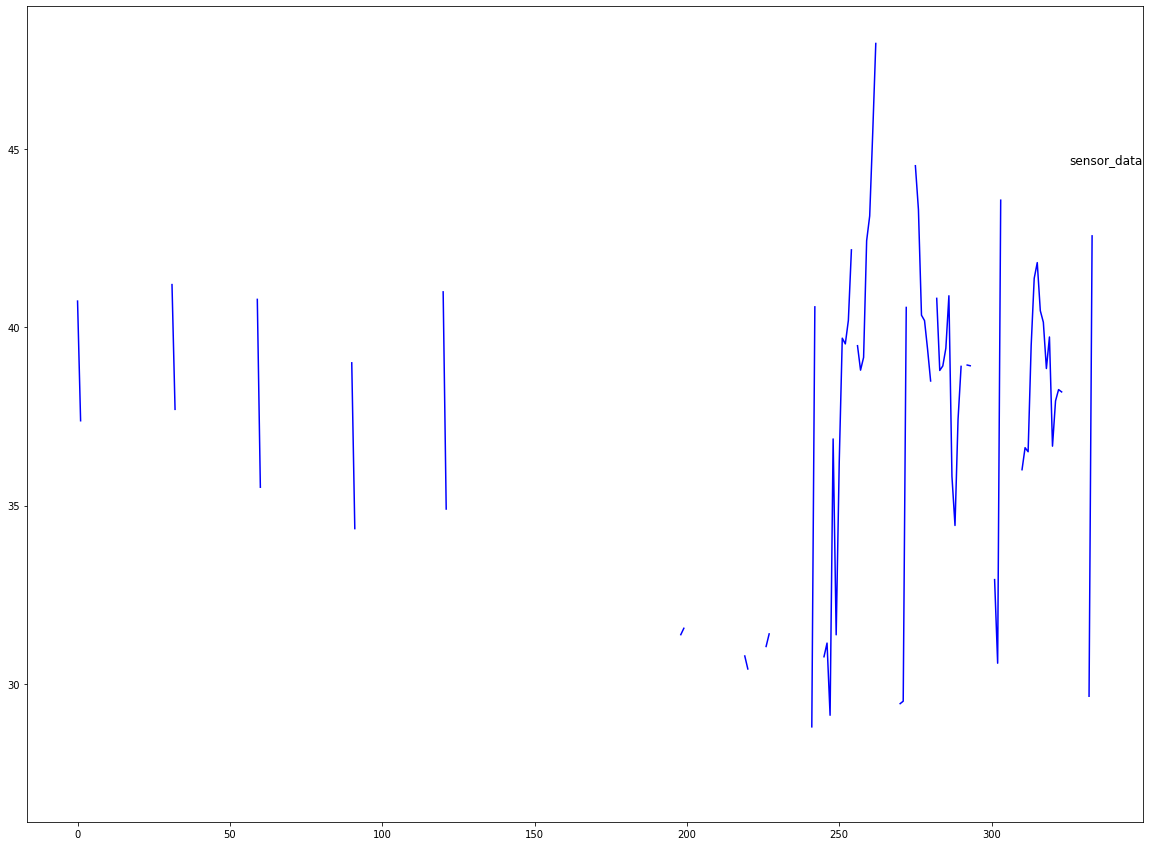

In [12]:
#Its imperative from autocorealtion plots that we dont need each minute data, perhaps we can decide roll up the aggregate
i = 1
# plot each column
plt.figure(figsize=(20, 15))
print(clean_data.columns)
for counter in range(1):
    plt.subplot(1, 1, i)
    plt.plot(clean_data.resample('D').mean().values[:, counter], color = 'blue')
    plt.title(clean_data.columns[counter], y=0.8, loc='right')
    i = i+1
plt.show()

In [13]:
#Credit: Adopted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

**3. Problem formulation and training LSTM**

In [14]:
#framing the problem
#resample over day

## resampling of data over hour
resampled_data = clean_data.resample('H').mean() 
resampled_data.shape

(8016, 1)

Now before moving forward, I would like to point out that you could potentially normalise the data in the data preprocessign phase and later decode it, i have left it out intentionally here as it made no difference in results.

In [15]:
# Feature engineering for LSTM
reframed_data = series_to_supervised(clean_data, 1, 1)
print(reframed_data.head())

                     var1(t-1)  var1(t)
time                                   
2018-08-12 09:30:00       29.0       29
2018-08-12 09:29:00       29.0       41
2018-08-12 09:29:00       41.0       41
2018-08-12 09:29:00       41.0       31
2018-08-12 09:29:00       31.0       31


In [16]:
# split into train and test sets
# 3020
values = reframed_data.values
train_index = 68324 #The logic is to have 500 days worth of training data. this could also be a hyperparameter that can be tuned.
train = values[:train_index, :]
test = values[train_index:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(68324, 1, 1) (68324,) (29281, 1, 1) (29281,)


This problem is mapped as many to one with stacked LSTMs with dropouts to control fitting. Loss is measured in MSE and optimised using adam optimizer.
Hyperparameter tuning: Technically I should be doing a grid/bayesian/random search on parameters like number of nuerons, dropouts, etc and get the parameters with least MSE. Beyond scope of this notebook.

Epoch 1/10
3417/3417 [==============================] - 26s 6ms/step - loss: 85.4466 - val_loss: 6.0892
Epoch 2/10
3417/3417 [==============================] - 18s 5ms/step - loss: 16.4314 - val_loss: 5.9078
Epoch 3/10
3417/3417 [==============================] - 18s 5ms/step - loss: 15.8353 - val_loss: 5.7168
Epoch 4/10
3417/3417 [==============================] - 19s 6ms/step - loss: 15.4428 - val_loss: 5.6060
Epoch 5/10
3417/3417 [==============================] - 19s 5ms/step - loss: 15.4102 - val_loss: 5.9340
Epoch 6/10
3417/3417 [==============================] - 19s 6ms/step - loss: 15.2409 - val_loss: 6.1426
Epoch 7/10
3417/3417 [==============================] - 19s 5ms/step - loss: 15.3516 - val_loss: 6.6732
Epoch 8/10
3417/3417 [==============================] - 19s 5ms/step - loss: 15.0962 - val_loss: 6.0982
Epoch 9/10
3417/3417 [==============================] - 18s 5ms/step - loss: 14.9464 - val_loss: 6.4414
Epoch 10/10
3417/3417 [==============================] - 18s 5ms

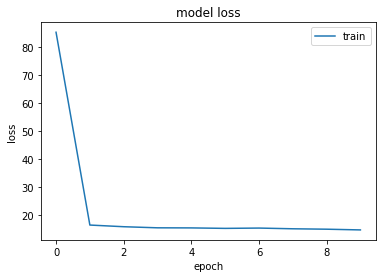

In [17]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=20, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [18]:
# make a prediction
yhat = model.predict(test_X, verbose=0)
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.483


Plot Actual vs Predicted

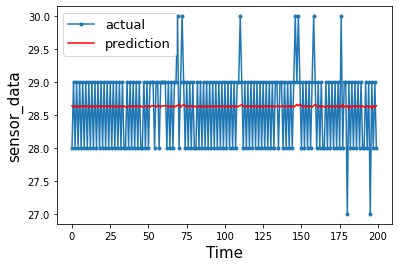

In [19]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, test_y[:200], marker='.', label="actual")
plt.plot(aa, yhat[:200], 'r', label="prediction")
plt.ylabel('sensor_data', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()